In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape to add a channel dimension for grayscale images
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Resize images to 32x32 for MobileNetV2
x_train = tf.image.resize(x_train, (32, 32)).numpy()  # Convert to NumPy array
x_test = tf.image.resize(x_test, (32, 32)).numpy()    # Convert to NumPy array

# Convert grayscale (1 channel) to RGB (3 channels) for MobileNetV2
x_train = np.repeat(x_train, 3, axis=-1)  # Repeat across the last dimension to make it (32, 32, 3)
x_test = np.repeat(x_test, 3, axis=-1)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.3
)
datagen.fit(x_train)

# Define the input
input_layer = Input(shape=(32, 32, 3))

# Load MobileNetV2 as base model
base_model = MobileNet(weights="imagenet", include_top=False, input_tensor=input_layer)

# Add Dense layer
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
output = Dense(10, activation="softmax")(x)

# Create the full model
model = Model(inputs=input_layer, outputs=output)

# Set a custom learning rate
learning_rate = 0.001  # You can adjust this as needed
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

# Early stopping callback
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(np.array(x_train), y_train, batch_size=32),
    validation_data=(np.array(x_val), y_val),
    epochs=20,
    callbacks=[early_stop]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(np.array(x_test), y_test)
print(f"Test Accuracy: {test_acc}")

# Save the model
model.save("fashion_mnist_mobilenet.h5")

# Save x_test and y_test for evaluation
np.save("x_test.npy", x_test)
np.save("y_test.npy", y_test)


<ipython-input-7-6248e5c6ca6a>:46: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights="imagenet", include_top=False, input_tensor=input_layer)


Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 546s 349ms/step - loss: 1.0366 - sparse_categorical_accuracy: 0.6552 - val_loss: 0.4555 - val_sparse_categorical_accuracy: 0.8381
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 557s 346ms/step - loss: 0.5694 - sparse_categorical_accuracy: 0.8006 - val_loss: 0.4484 - val_sparse_categorical_accuracy: 0.8356
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 521s 347ms/step - loss: 0.5148 - sparse_categorical_accuracy: 0.8238 - val_loss: 0.5304 - val_sparse_categorical_accuracy: 0.8152
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 520s 347ms/step - loss: 0.4727 - sparse_categorical_accuracy: 0.8347 - val_loss: 0.4231 - val_sparse_categorical_accuracy: 0.8528
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 526s 351ms/step - loss: 0.4520 - sparse_categorical_accuracy: 0.8413 - val_loss: 0.6906 - val_sparse_categorical_accuracy: 0.7930
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 525s 350ms/step - loss: 0.4440 - sparse_categorical_accuracy: 0.8455 - val_loss: 0.3795 - val_spar

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step
Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.86      0.84      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.82      0.85      1000
       Dress       0.91      0.82      0.86      1000
        Coat       0.84      0.86      0.85      1000
      Sandal       0.99      0.96      0.97      1000
       Shirt       0.68      0.74      0.71      1000
     Sneaker       0.91      0.98      0.94      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.98      0.93      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



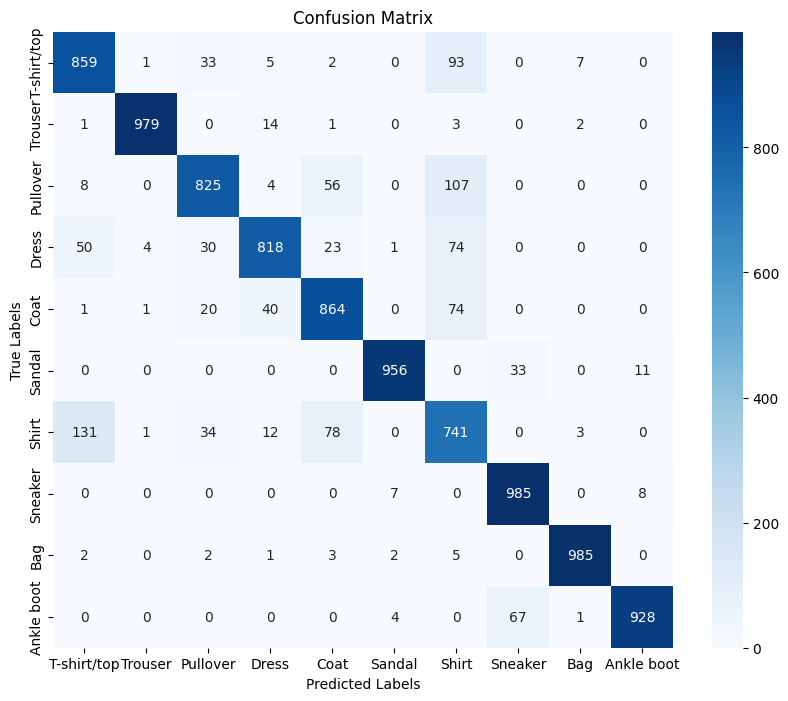

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# Load x_test and y_test
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

# Load the trained model
model = load_model('fashion_mnist_mobilenet.h5')
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
# Predict classes for x_test
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate a classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()